In [131]:
#Boiler plate imports
import uproot 
import pandas as pd
import sys
import matplotlib.pyplot as plt
import numpy as np
from time import time
from scipy.interpolate import interp1d

import xml.etree.ElementTree as ET

#SBND imports
sys.path.append('/sbnd/app/users/brindenc/mysbnana_v09_75_03/srcs/sbnana/sbnana/SBNAna/pyana')
from sbnd.general import utils,plotters
from sbnd.plotlibrary import makeplot
from sbnd import stats as sbndstats

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [132]:
#Variables
prism_bin = 3
save_plots = True

#Constants/variables
PLOTS_DIR = f'Plots/gevgencc_prism_bin{prism_bin}_{plotters.day}'

CRPA_LABEL = 'HF-CRPA (G21_11a)'
G21_LABEL = 'SuSAv2 (G21_11a)'
G18_LABEL = 'NAV (G18_10a_02_11a)'
HYBRID_LABEL = 'HF-CRPA SuSAv2 (G21_11a)'

PRISM_BINS = [0,0.2,0.4,0.6,0.8,1.0,1.2,1.4,1.6,1.8]

SIM_LABEL = r'100k $\nu_\mu$ CC GENIE SBND'+ '\n' + r'$\theta_{PRISM} \in$' + f'[{PRISM_BINS[prism_bin]},{PRISM_BINS[prism_bin+1]})'

## Load data

In [133]:
fname_crpa = '/sbnd/data/users/brindenc/genie/crpa/gevgens/numu/CRPA/CCQE_CRPAG21_11a_00_000_sbnd_100k.root'
fname_crpa_prism = f'/sbnd/data/users/brindenc/genie/crpa/gevgens/numu/CRPA/prism/genie_tree_prism_bin{prism_bin}.root'
tree_crpa = uproot.open(fname_crpa_prism)['genie_tree;1']
df_crpa = tree_crpa.arrays(library='pd')

fname_g21 = '/sbnd/data/users/brindenc/genie/crpa/gevgens/numu/G21/CCQE_G21_11a_00_000_sbnd_100k.root'
fname_g21_prism = f'/sbnd/data/users/brindenc/genie/crpa/gevgens/numu/G21/prism/genie_tree_prism_bin{prism_bin}.root'
tree_g21 = uproot.open(fname_g21_prism)['genie_tree;1']
df_g21 = tree_g21.arrays(library='pd')

fname_g18 = '/sbnd/data/users/brindenc/genie/crpa/gevgens/numu/G18/CCQE_G18_10a_02_11a_sbnd_100k.root'
fname_g18_prism = f'/sbnd/data/users/brindenc/genie/crpa/gevgens/numu/G18/prism/genie_tree_prism_bin{prism_bin}.root'
tree_g18 = uproot.open(fname_g18_prism)['genie_tree;1']
df_g18 = tree_g18.arrays(library='pd')

fname_hybrid = '/sbnd/data/users/brindenc/genie/crpa/gevgens/numu/CRPASuSAv2/CCQE_HybridG21_11a_00_000_sbnd_100k.root'
fname_hybrid_prism = f'/sbnd/data/users/brindenc/genie/crpa/gevgens/numu/CRPASuSAv2/prism/genie_tree_prism_bin{prism_bin}.root'
tree_hybrid = uproot.open(fname_hybrid_prism)['genie_tree;1']
df_hybrid = tree_hybrid.arrays(library='pd')

#fname_sbnd_flux = '/sbnd/data/users/brindenc/genie/crpa/splines/sbnd_flux.root'
#hist_sbnd_flux = uproot.open(fname_sbnd_flux)['flux_sbnd_numu;1'] #make sure to use correct flux

fname_sbnd_prism_flux = '/sbnd/data/users/brindenc/genie/crpa/splines/prism_fluxes.root'
hist_sbnd_flux = uproot.open(fname_sbnd_prism_flux)[f'prism_flux_{prism_bin};1'] #make sure to use correct flux

## Clean Data

In [134]:
df_crpa['final_mu_p'] = np.linalg.norm(df_crpa[['final_mu_px','final_mu_py','final_mu_pz']].values,axis=1)
df_crpa['final_mu_theta'] = np.arccos(df_crpa.final_mu_pz/df_crpa.final_mu_p)
df_crpa['w'] = df_crpa.initialnu_E - df_crpa.final_mu_E

df_g21['final_mu_p'] = np.linalg.norm(df_g21[['final_mu_px','final_mu_py','final_mu_pz']].values,axis=1)
df_g21['final_mu_theta'] = np.arccos(df_g21.final_mu_pz/df_g21.final_mu_p)
df_g21['w'] = df_g21.initialnu_E - df_g21.final_mu_E

df_g18['final_mu_p'] = np.linalg.norm(df_g18[['final_mu_px','final_mu_py','final_mu_pz']].values,axis=1)
df_g18['final_mu_theta'] = np.arccos(df_g18.final_mu_pz/df_g18.final_mu_p)
df_g18['w'] = df_g18.initialnu_E - df_g18.final_mu_E

df_hybrid['final_mu_p'] = np.linalg.norm(df_hybrid[['final_mu_px','final_mu_py','final_mu_pz']].values,axis=1)
df_hybrid['final_mu_theta'] = np.arccos(df_hybrid.final_mu_pz/df_hybrid.final_mu_p)
df_hybrid['w'] = df_hybrid.initialnu_E - df_hybrid.final_mu_E

values_sbnd_flux = hist_sbnd_flux.values()
edges_sbnd_flux = hist_sbnd_flux.axis().edges()
centers_sbnd_flux = (edges_sbnd_flux[:-1] + edges_sbnd_flux[1:])/2

#Make flux spline
flux_interp = interp1d(centers_sbnd_flux,values_sbnd_flux,kind='cubic',fill_value='extrapolate')

df_crpa.keys()

Index(['final_mu_E', 'final_mu_px', 'final_mu_py', 'final_mu_pz',
       'initialnu_pdg', 'initialnu_E', 'initialnu_px', 'initialnu_py',
       'initialnu_pz', 'xsecs', 'dxsecs', 'dxsec_vars', 'y', 'Q2', 'W',
       'final_mu_p', 'final_mu_theta', 'w'],
      dtype='object')

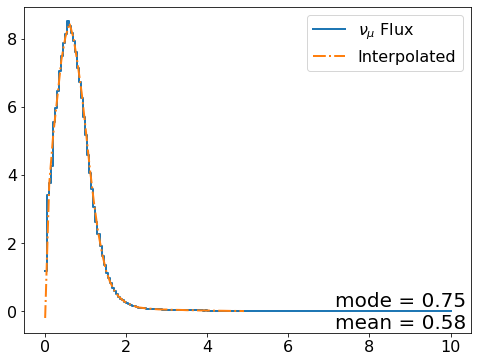

In [135]:
#Check flux spline
fig,ax = plt.subplots(figsize=(8,6))
Es = np.arange(0.01,5,0.1)
makeplot.plot_hist_edges(edges_sbnd_flux,values_sbnd_flux,None,r'$\nu_\mu$ Flux',ax=ax,lw=2)
ax.plot(Es,flux_interp(Es),label='Interpolated',lw=2,linestyle='-.')
ax.legend()
plotters.set_style(ax)
plotters.add_label(ax,f'mode = {sbndstats.calc_mean_hist(values_sbnd_flux,edges_sbnd_flux):.2f}'\
                    '\n'+f'mean = {sbndstats.calc_mode_hist(values_sbnd_flux,edges_sbnd_flux):.2f}'
                   ,where='bottomright'
                   ,fontsize=20)

plotters.save_plot('flux_check',fig=fig,folder_name=PLOTS_DIR)

## Set weights of events

In [136]:
weights_crpa = df_crpa['xsecs']*flux_interp(df_crpa['initialnu_E'])
weights_g18 = df_g18['xsecs']*flux_interp(df_g18['initialnu_E'])
weights_g21 = df_g21['xsecs']*flux_interp(df_g21['initialnu_E'])
weights_hybrid = df_hybrid['xsecs']*flux_interp(df_hybrid['initialnu_E'])

#Normalize weights to largest weight
norm = np.max([np.max(weights_crpa),np.max(weights_g18),np.max(weights_g21),np.max(weights_hybrid)])

df_crpa['weights'] = weights_crpa/norm
df_g18['weights'] = weights_g18/norm
df_g21['weights'] = weights_g21/norm
df_hybrid['weights'] = weights_hybrid/norm

## Events by muon kinematics

In [137]:
#Bins for plotting
costheta_bins = np.array([-1,-0.5,0,0.27,0.45,0.62,0.76,0.86,0.94,1])
theta_bins = np.arccos(costheta_bins)

p_bins = np.array([0,0.3,0.5,0.7,0.9,1.1,1.3,1.5,2,3])

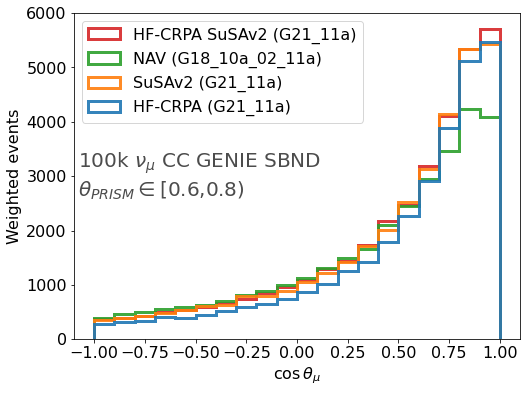

In [138]:
fig,ax = plt.subplots(figsize=(8,6))
ax.hist([np.cos(df_crpa.final_mu_theta),np.cos(df_g21.final_mu_theta),np.cos(df_g18.final_mu_theta),np.cos(df_hybrid.final_mu_theta),],
        bins=np.arange(-1,1.1,0.1),
        histtype='step',
        lw=3,
        alpha=0.9,
        label=[CRPA_LABEL,G21_LABEL,G18_LABEL,HYBRID_LABEL],
        weights=[df_crpa.weights,df_g21.weights,df_g18.weights,df_hybrid.weights],
        density=False)

ax.legend()
ax.set_xlabel(r'$\cos\theta_\mu$')
ax.set_ylabel('Weighted events')

plotters.set_style(ax,legend_loc='upper left')
plotters.add_label(ax,SIM_LABEL,where='centerleft',fontsize=20,alpha=0.7)

if save_plots:
  plotters.save_plot('ccnumu_costheta',fig=fig,folder_name=PLOTS_DIR)

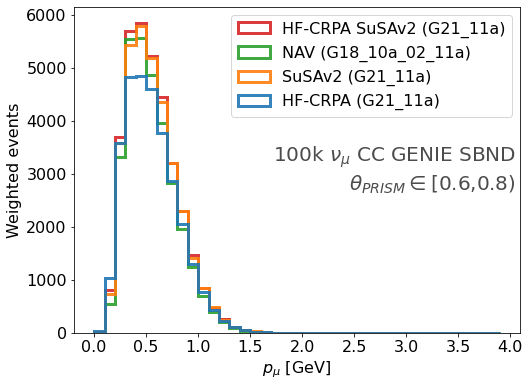

In [139]:
fig,ax = plt.subplots(figsize=(8,6))
ax.hist([df_crpa.final_mu_p,df_g21.final_mu_p,df_g18.final_mu_p,df_hybrid.final_mu_p],
        bins=np.arange(0,4,0.1),
        histtype='step',
        lw=3,
        label=[CRPA_LABEL,G21_LABEL,G18_LABEL,HYBRID_LABEL],
        density=False,
        weights=[df_crpa.weights,df_g21.weights,df_g18.weights,df_hybrid.weights],
        alpha=0.9)

ax.legend()
ax.set_xlabel(r'$p_\mu$ [GeV]')
ax.set_ylabel('Weighted events')

plotters.set_style(ax,legend_loc='upper right')
plotters.add_label(ax,SIM_LABEL,where='centerright',fontsize=20,alpha=0.7)

if save_plots:
  plotters.save_plot('ccnumu_momentum',fig=fig,folder_name=PLOTS_DIR)

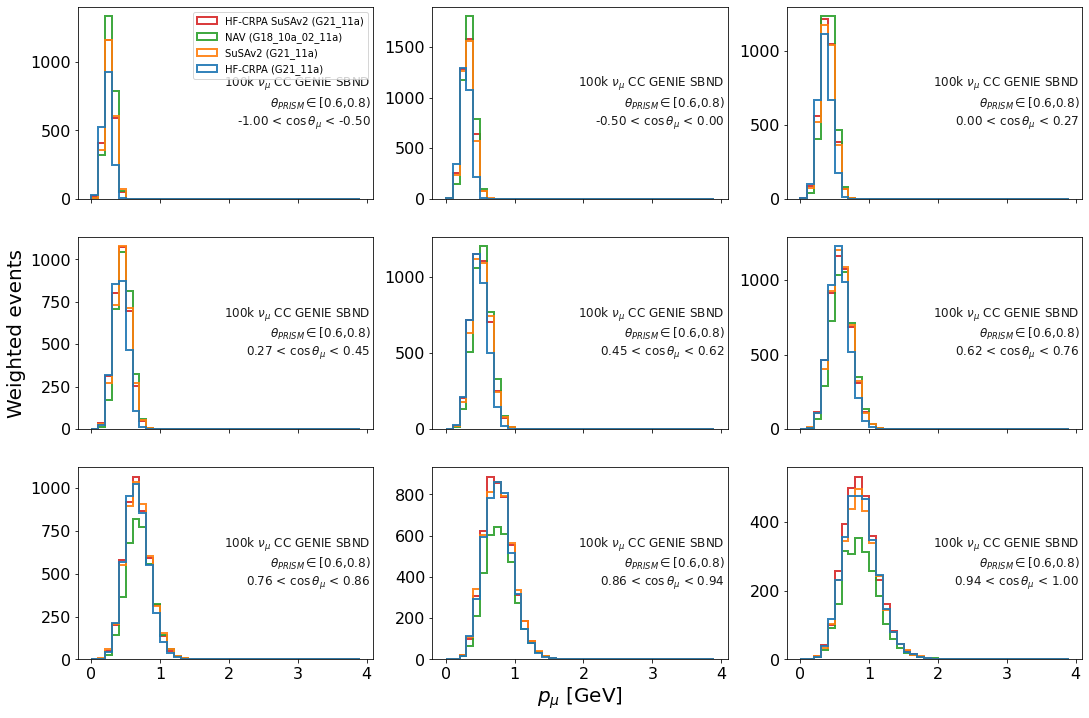

In [140]:
fig,axs = plt.subplots(nrows=3,ncols=3,figsize=(18,12),sharex=True)
for i,ax in enumerate(axs.flatten()):
  mask_crpa = (df_crpa.final_mu_theta < theta_bins[i]) & (df_crpa.final_mu_theta > theta_bins[i+1])
  mask_g21 = (df_g21.final_mu_theta < theta_bins[i]) & (df_g21.final_mu_theta > theta_bins[i+1])
  mask_g18 = (df_g18.final_mu_theta < theta_bins[i]) & (df_g18.final_mu_theta > theta_bins[i+1])
  mask_hybrid = (df_hybrid.final_mu_theta < theta_bins[i]) & (df_hybrid.final_mu_theta > theta_bins[i+1])
  
  ps_crpa = df_crpa[mask_crpa].final_mu_p
  ps_g21 = df_g21[mask_g21].final_mu_p
  ps_g18 = df_g18[mask_g18].final_mu_p
  ps_hybrid = df_hybrid[mask_hybrid].final_mu_p
  ax.hist([ps_crpa,ps_g21,ps_g18,ps_hybrid],
          bins=np.arange(0,4,0.1),
          histtype='step',
          lw=2,
          alpha=0.9,
          label=[CRPA_LABEL,G21_LABEL,G18_LABEL,HYBRID_LABEL],
          weights=[df_crpa[mask_crpa].weights,df_g21[mask_g21].weights,df_g18[mask_g18].weights,df_hybrid[mask_hybrid].weights],
          density=False)
  #ax.legend()
  plotters.set_style(ax)
  plotters.add_label(ax,SIM_LABEL+f'\n{costheta_bins[i]:.2f} < $\cos\\theta_\mu$ < {costheta_bins[i+1]:.2f}',fontsize=12,alpha=0.9,where='centerright')
axs[2,1].set_xlabel(r'$p_\mu$ [GeV]',fontsize=20)
axs[1,0].set_ylabel('Weighted events',fontsize=20)
axs[0,0].legend(fontsize=10)

if save_plots:
  plotters.save_plot('ccnumu_momentum_binned',fig=fig,folder_name=PLOTS_DIR)

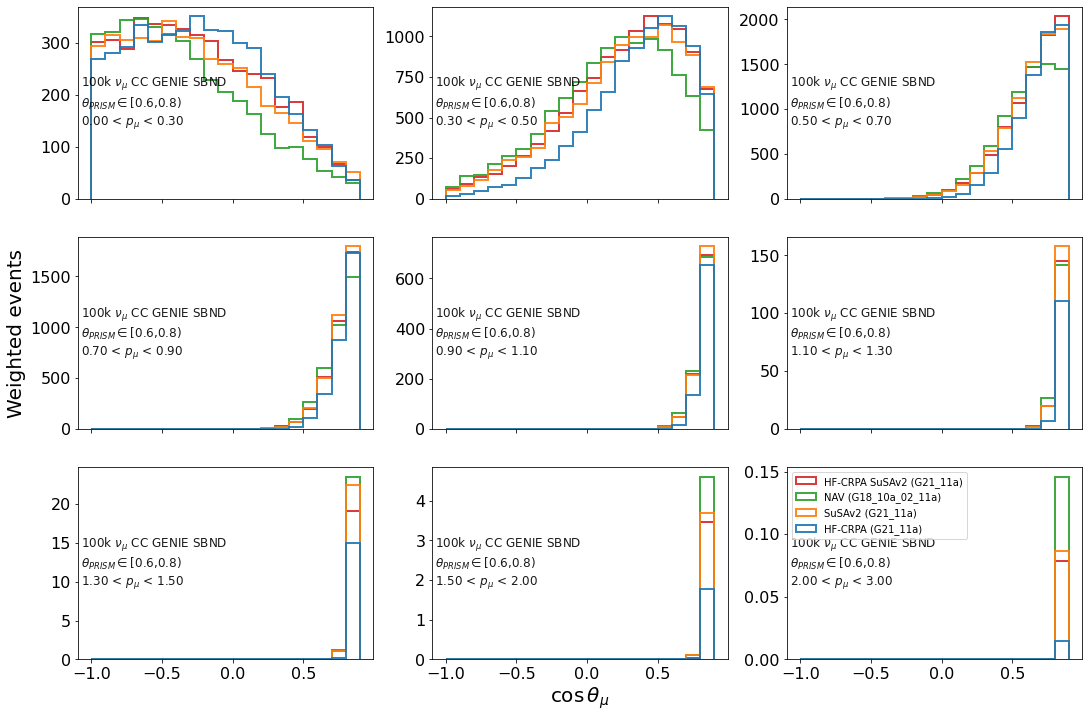

In [141]:
fig,axs = plt.subplots(nrows=3,ncols=3,figsize=(18,12),sharex=True)
for i,ax in enumerate(axs.flatten()):
  crpa_mask = (df_crpa.final_mu_p > p_bins[i]) & (df_crpa.final_mu_p < p_bins[i+1])
  costhetas_crpa = np.cos(df_crpa[crpa_mask].final_mu_theta)*np.sign(df_crpa[crpa_mask].final_mu_theta)
  
  g21_mask = (df_g21.final_mu_p > p_bins[i]) & (df_g21.final_mu_p < p_bins[i+1])
  costhetas_g21 = np.cos(df_g21[g21_mask].final_mu_theta)*np.sign(df_g21[g21_mask].final_mu_theta)
  
  g18_mask = (df_g18.final_mu_p > p_bins[i]) & (df_g18.final_mu_p < p_bins[i+1])
  costhetas_g18 = np.cos(df_g18[g18_mask].final_mu_theta)*np.sign(df_g18[g18_mask].final_mu_theta)
  
  hybrid_mask = (df_hybrid.final_mu_p > p_bins[i]) & (df_hybrid.final_mu_p < p_bins[i+1])
  costhetas_hybrid = np.cos(df_hybrid[hybrid_mask].final_mu_theta)*np.sign(df_hybrid[hybrid_mask].final_mu_theta)
  
  ax.hist([costhetas_crpa,costhetas_g21,costhetas_g18,costhetas_hybrid],
          bins=np.arange(-1,1,0.1),
          histtype='step',
          lw=2,
          alpha=0.9,
          label=[CRPA_LABEL,G21_LABEL,G18_LABEL,HYBRID_LABEL],
          weights=[df_crpa[crpa_mask].weights,df_g21[g21_mask].weights,df_g18[g18_mask].weights,df_hybrid[hybrid_mask].weights],
          density=False)
  #ax.legend()
  plotters.set_style(ax)
  plotters.add_label(ax,SIM_LABEL+f'\n{p_bins[i]:.2f} < $p_\mu$ < {p_bins[i+1]:.2f}',fontsize=12,alpha=0.9,where='centerleft')
axs[2,1].set_xlabel(r'$\cos \theta_\mu$',fontsize=20)
axs[1,0].set_ylabel('Weighted events',fontsize=20)
axs[2,2].legend(fontsize=10,loc='upper left')

if save_plots:
  plotters.save_plot('ccnumu_costheta_binned',fig=fig,folder_name=PLOTS_DIR)

## XSec plots

In [142]:
#Sort by neutrino energy
df_crpa.sort_values('initialnu_E',inplace=True)
df_g21.sort_values('initialnu_E',inplace=True)
df_g18.sort_values('initialnu_E',inplace=True)
df_hybrid.sort_values('initialnu_E',inplace=True)

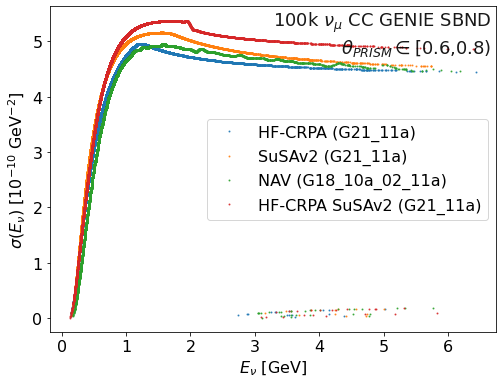

In [143]:
fig,ax = plt.subplots(figsize=(8,6))
ax.plot(df_crpa.initialnu_E,df_crpa.xsecs*1e10,'.',markersize=2,alpha=0.8,label=CRPA_LABEL)
ax.plot(df_g21.initialnu_E,df_g21.xsecs*1e10,'.',markersize=2,alpha=0.8,label=G21_LABEL)
ax.plot(df_g18.initialnu_E,df_g18.xsecs*1e10,'.',markersize=2,alpha=0.8,label=G18_LABEL)
ax.plot(df_hybrid.initialnu_E,df_hybrid.xsecs*1e10,'.',markersize=2,alpha=0.8,label=HYBRID_LABEL)

ax.legend()

ax.set_xlabel(r'$E_\nu$ [GeV]')
ax.set_ylabel(r'$\sigma(E_\nu)$ [10$^{-10}$ GeV$^{-2}$]')


plotters.set_style(ax)
plotters.add_label(ax,SIM_LABEL,where='topright',fontsize=18,alpha=0.9)

if save_plots:
  plotters.save_plot('ccnumu_xsec_Ev',fig=fig,folder_name=PLOTS_DIR)

In [144]:
#Sort by energy transfer
df_crpa.sort_values('w',inplace=True)
df_g21.sort_values('w',inplace=True)
df_g18.sort_values('w',inplace=True)
df_hybrid.sort_values('w',inplace=True)

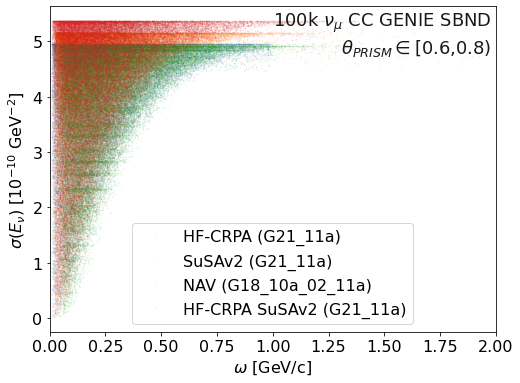

In [145]:
fig,ax = plt.subplots(figsize=(8,6))
ax.plot(df_crpa.w,df_crpa.xsecs*1e10,'.',markersize=1,alpha=0.1,label=CRPA_LABEL)
ax.plot(df_g21.w,df_g21.xsecs*1e10,'.',markersize=1,alpha=0.1,label=G21_LABEL)
ax.plot(df_g18.w,df_g18.xsecs*1e10,'.',markersize=1,alpha=0.1,label=G18_LABEL)
ax.plot(df_hybrid.w,df_hybrid.xsecs*1e10,'.',markersize=1,alpha=0.1,label=HYBRID_LABEL)

ax.legend()

ax.set_xlim([0,2])

ax.set_xlabel(r'$\omega$ [GeV/c]')
ax.set_ylabel(r'$\sigma(E_\nu)$ [10$^{-10}$ GeV$^{-2}$]')


plotters.set_style(ax)
plotters.add_label(ax,SIM_LABEL,where='topright',fontsize=18,alpha=0.9)

if save_plots:
  plotters.save_plot('ccnumu_xsec_w',fig=fig,folder_name=PLOTS_DIR)

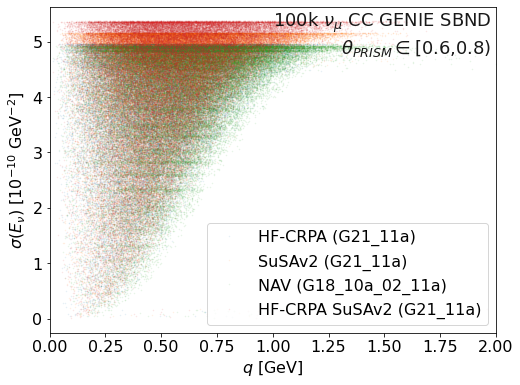

In [146]:
fig,ax = plt.subplots(figsize=(8,6))
ax.plot(np.sqrt(df_crpa.Q2),df_crpa.xsecs*1e10,'.',markersize=1,alpha=0.1,label=CRPA_LABEL)
ax.plot(np.sqrt(df_g21.Q2),df_g21.xsecs*1e10,'.',markersize=1,alpha=0.1,label=G21_LABEL)
ax.plot(np.sqrt(df_g18.Q2),df_g18.xsecs*1e10,'.',markersize=1,alpha=0.1,label=G18_LABEL)
ax.plot(np.sqrt(df_hybrid.Q2),df_hybrid.xsecs*1e10,'.',markersize=1,alpha=0.1,label=HYBRID_LABEL)

ax.legend()

ax.set_xlim([0,2])

ax.set_xlabel(r'$q$ [GeV]')
ax.set_ylabel(r'$\sigma(E_\nu)$ [10$^{-10}$ GeV$^{-2}$]')


plotters.set_style(ax)
plotters.add_label(ax,SIM_LABEL,where='topright',fontsize=18,alpha=0.9)

if save_plots:
  plotters.save_plot('ccnumu_xsec_q',fig=fig,folder_name=PLOTS_DIR)

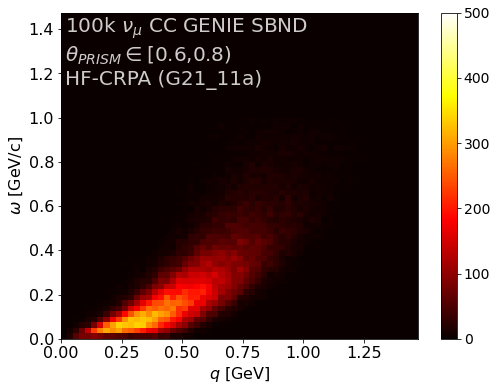

In [147]:
fig,ax = plt.subplots(figsize=(8,6))
im = ax.hist2d(np.sqrt(df_crpa.Q2),df_crpa.initialnu_E-df_crpa.final_mu_E,
          cmap='hot',bins=np.arange(0,1.5,0.025))

ax.set_xlabel(r'$q$ [GeV]')
ax.set_ylabel(r'$\omega$ [GeV/c]')

cbar = fig.colorbar(im[3],ax=ax)
cbar.ax.tick_params(labelsize=14)
im[3].set_clim(0,500)

plotters.set_style(ax)
plotters.add_label(ax,SIM_LABEL+'\n'+f'{CRPA_LABEL}',where='topleft',fontsize=20,alpha=0.8,color='white')

if save_plots:
  plotters.save_plot('ccnumu_crpa_omega_q',fig=fig,folder_name=PLOTS_DIR)

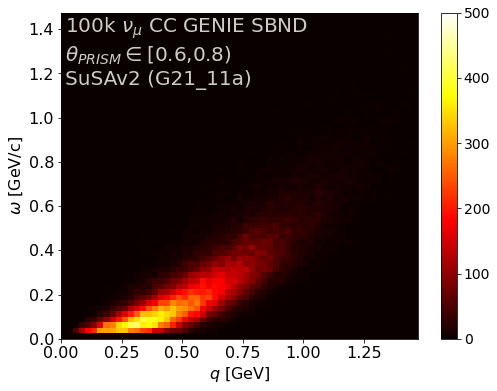

In [148]:
fig,ax = plt.subplots(figsize=(8,6))
im = ax.hist2d(np.sqrt(df_g21.Q2),df_g21.initialnu_E-df_g21.final_mu_E,
          cmap='hot',bins=np.arange(0,1.5,0.025))

ax.set_xlabel(r'$q$ [GeV]')
ax.set_ylabel(r'$\omega$ [GeV/c]')

cbar = fig.colorbar(im[3],ax=ax)
cbar.ax.tick_params(labelsize=14)
im[3].set_clim(0,500)

plotters.set_style(ax)
plotters.add_label(ax,SIM_LABEL+'\n'+f'{G21_LABEL}',where='topleft',fontsize=20,alpha=0.8,color='white')

if save_plots:
  plotters.save_plot('ccnumu_g21_omega_q',fig=fig,folder_name=PLOTS_DIR)

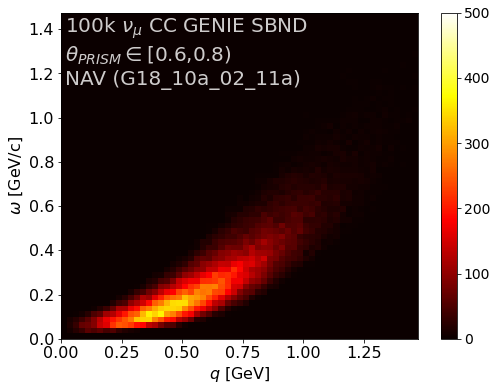

In [149]:
fig,ax = plt.subplots(figsize=(8,6))
im = ax.hist2d(np.sqrt(df_g18.Q2),df_g18.initialnu_E-df_g18.final_mu_E,
          cmap='hot',bins=np.arange(0,1.5,0.025))

ax.set_xlabel(r'$q$ [GeV]')
ax.set_ylabel(r'$\omega$ [GeV/c]')

cbar = fig.colorbar(im[3],ax=ax)
cbar.ax.tick_params(labelsize=14)
im[3].set_clim(0,500)

plotters.set_style(ax)
plotters.add_label(ax,SIM_LABEL+'\n'+f'{G18_LABEL}',where='topleft',fontsize=20,alpha=0.8,color='white')

if save_plots:
  plotters.save_plot('ccnumu_g18_omega_q',fig=fig,folder_name=PLOTS_DIR)

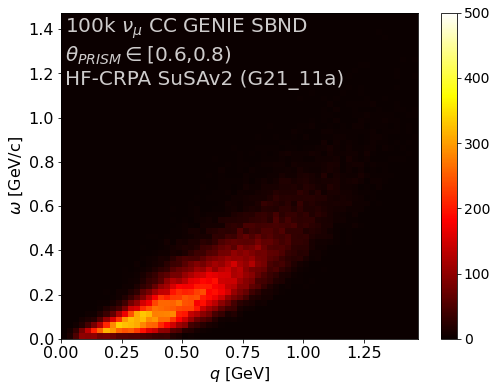

In [150]:
fig,ax = plt.subplots(figsize=(8,6))
im = ax.hist2d(np.sqrt(df_hybrid.Q2),df_hybrid.initialnu_E-df_hybrid.final_mu_E,
          cmap='hot',bins=np.arange(0,1.5,0.025))

ax.set_xlabel(r'$q$ [GeV]')
ax.set_ylabel(r'$\omega$ [GeV/c]')

cbar = fig.colorbar(im[3],ax=ax)
cbar.ax.tick_params(labelsize=14)
im[3].set_clim(0,500)

plotters.set_style(ax)
plotters.add_label(ax,SIM_LABEL+'\n'+f'{HYBRID_LABEL}',where='topleft',fontsize=20,alpha=0.8,color='white')

if save_plots:
  plotters.save_plot('ccnumu_hybrid_omega_q',fig=fig,folder_name=PLOTS_DIR)

## Events by interaction kinematics

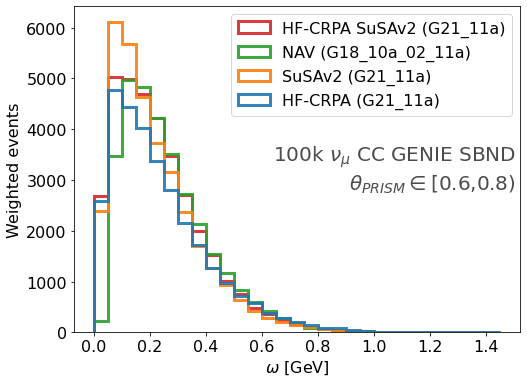

In [151]:
fig,ax = plt.subplots(figsize=(8,6))
ax.hist([df_crpa.w,df_g21.w,df_g18.w,df_hybrid.w],
        bins=np.arange(0,1.5,0.05),
        histtype='step',
        lw=3,
        label=[CRPA_LABEL,G21_LABEL,G18_LABEL,HYBRID_LABEL],
        density=False,
        weights=[df_crpa.weights,df_g21.weights,df_g18.weights,df_hybrid.weights],
        alpha=0.9)

ax.legend()
ax.set_xlabel(r'$\omega$ [GeV]')
ax.set_ylabel('Weighted events')

plotters.set_style(ax,legend_loc='upper right')
plotters.add_label(ax,SIM_LABEL,where='centerright',fontsize=20,alpha=0.7)

if save_plots:
  plotters.save_plot('ccnumu_energy_transfer',fig=fig,folder_name=PLOTS_DIR)

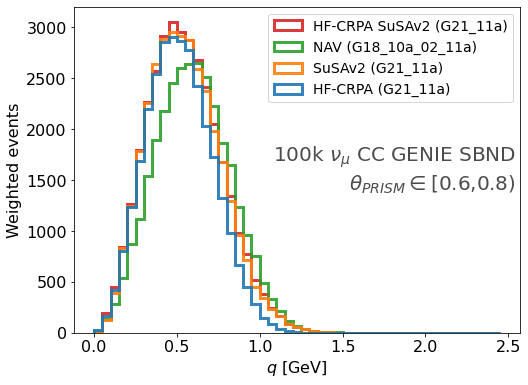

In [152]:
fig,ax = plt.subplots(figsize=(8,6))
ax.hist([np.sqrt(df_crpa.Q2),np.sqrt(df_g21.Q2),np.sqrt(df_g18.Q2),np.sqrt(df_hybrid.Q2)],
        bins=np.arange(0,2.5,0.05),
        histtype='step',
        lw=3,
        label=[CRPA_LABEL,G21_LABEL,G18_LABEL,HYBRID_LABEL],
        density=False,
        weights=[df_crpa.weights,df_g21.weights,df_g18.weights,df_hybrid.weights],
        alpha=0.9)

ax.legend()
ax.set_xlabel(r'$q$ [GeV]')
ax.set_ylabel('Weighted events')

plotters.set_style(ax,legend_loc='upper right',legend_size=14)
plotters.add_label(ax,SIM_LABEL,where='centerright',fontsize=20,alpha=0.7)

if save_plots:
  plotters.save_plot('ccnumu_momentum_transfer',fig=fig,folder_name=PLOTS_DIR)

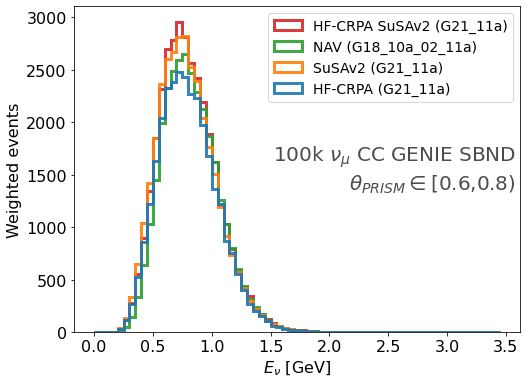

In [153]:
fig,ax = plt.subplots(figsize=(8,6))
values,edges,_ = ax.hist([df_crpa.initialnu_E,df_g21.initialnu_E,df_g18.initialnu_E,df_hybrid.initialnu_E],
        bins=np.arange(0,3.5,0.05),
        histtype='step',
        lw=3,
        label=[CRPA_LABEL,G21_LABEL,G18_LABEL,HYBRID_LABEL],
        density=False,
        weights=[df_crpa.weights,df_g21.weights,df_g18.weights,df_hybrid.weights],
        alpha=0.9)
np.savetxt('data/ccqenumu_enu_edges.txt',edges)
np.savetxt('data/ccqenumu_enu_crpa.txt',values[0])
np.savetxt('data/ccqenumu_enu_g21.txt',values[1])
np.savetxt('data/ccqenumu_enu_g18.txt',values[2])
np.savetxt('data/ccqenumu_enu_hybrid.txt',values[3])
ax.legend()
ax.set_xlabel(r'$E_\nu$ [GeV]')
ax.set_ylabel('Weighted events')

plotters.set_style(ax,legend_loc='upper right',legend_size=14)
plotters.add_label(ax,SIM_LABEL,where='centerright',fontsize=20,alpha=0.7)

if save_plots:
  plotters.save_plot('ccnumu_neutrino_energy',fig=fig,folder_name=PLOTS_DIR)